# Clasificaciones de imagenes con MobileNetV2

##BUILD ROBOCUP_2019 Dataset

###Dataset details
RoboCup Dataset contains 196195 images.

8 main parent categories that contain 180 children categories.

80% for train

20% for test


##Importar los paquetes

In [ ]:
from tensorflow import keras
import zipfile
import tensorflow as tf
import os
from google.colab import drive
import matplotlib.pyplot as plt


##MobileNetV2 for subclass

###LoadData

In [ ]:
drive.mount('/content/drive')
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_subclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 180

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './training_data'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 157028 images belonging to 180 classes.
Found 39167 images belonging to 180 classes.


### Build model - MobileNetV2

In [ ]:
base_model = keras.applications.MobileNetV2	(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Then, freeze the base model.
base_model.trainable = False

#Create a new model on top.
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(180, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 180)               230580    
                                                                 
Total params: 2,488,564
Trainable params: 230,580
Non-trainable params: 2,257,984
_________________________________________________________________


###Evaluate model

In [ ]:
from keras.api._v2.keras import callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model.compile(optimizer=keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                    tf.keras.metrics.Precision()])
history = model.fit(train_batches, epochs=20, validation_data=valid_batches, callbacks=[callback])


Epoch 1/20
4908/4908 [==============================] - 537s 108ms/step - loss: 4.4919 - accuracy: 0.1599 - top_5_accuracy: 0.3921 - precision: 0.2886 - val_loss: 3.5740 - val_accuracy: 0.2504 - val_top_5_accuracy: 0.5652 - val_precision: 0.3567
Epoch 2/20
4908/4908 [==============================] - 512s 104ms/step - loss: 3.8045 - accuracy: 0.2420 - top_5_accuracy: 0.5365 - precision: 0.3503 - val_loss: 3.4056 - val_accuracy: 0.2883 - val_top_5_accuracy: 0.6089 - val_precision: 0.3933
Epoch 3/20
4908/4908 [==============================] - 506s 103ms/step - loss: 3.6396 - accuracy: 0.2716 - top_5_accuracy: 0.5737 - precision: 0.3812 - val_loss: 3.3130 - val_accuracy: 0.3087 - val_top_5_accuracy: 0.6347 - val_precision: 0.4217
Epoch 4/20
4908/4908 [==============================] - 500s 102ms/step - loss: 3.4931 - accuracy: 0.2945 - top_5_accuracy: 0.6014 - precision: 0.4050 - val_loss: 3.1778 - val_accuracy: 0.3301 - val_top_5_accuracy: 0.6474 - val_precision: 0.4482
Epoch 5/20
4908/

###print results

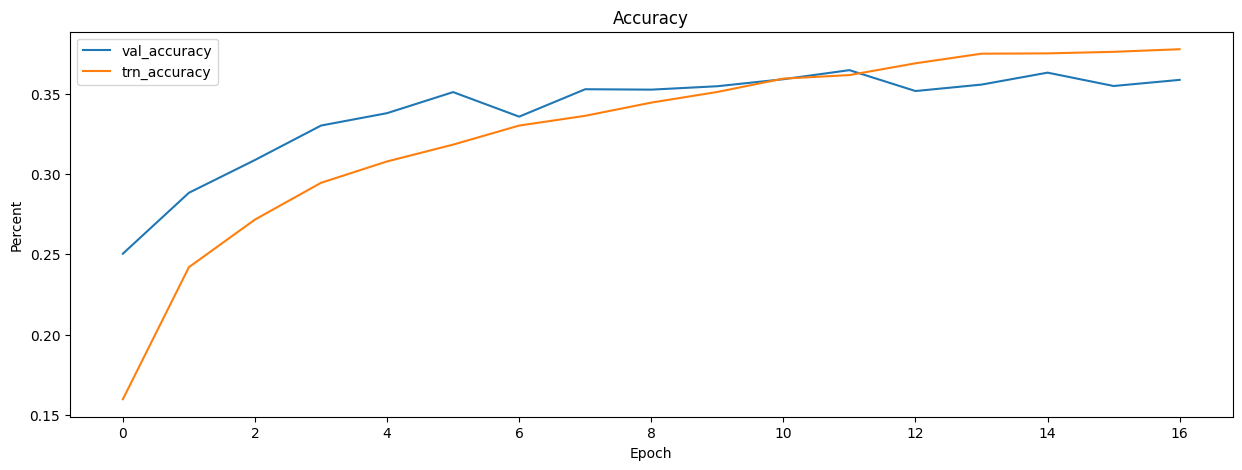

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_accuracy'],label='val_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['accuracy'],label='trn_accuracy')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

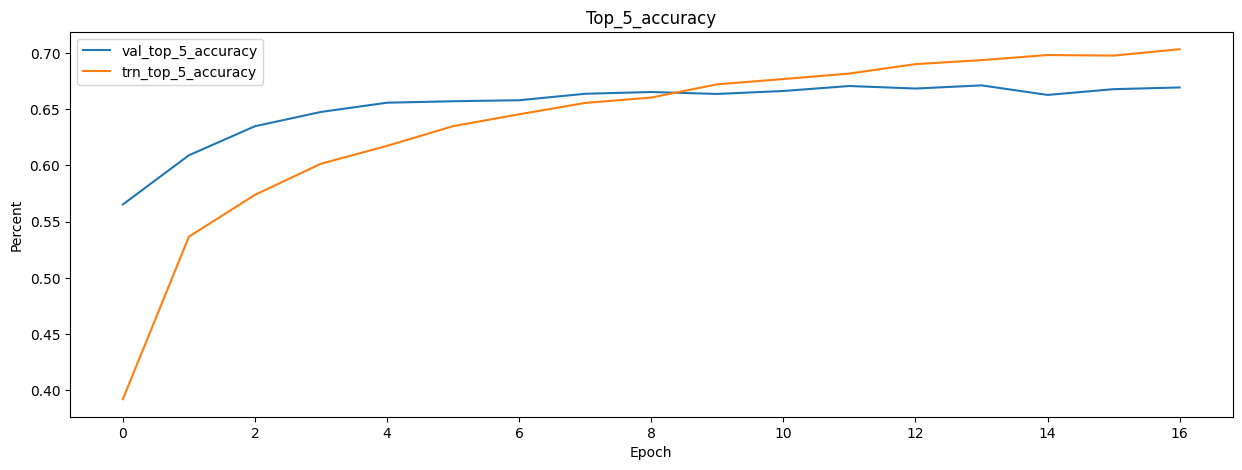

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_top_5_accuracy'],label='val_top_5_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['top_5_accuracy'],label='trn_top_5_accuracy')
plt.title('Top_5_accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

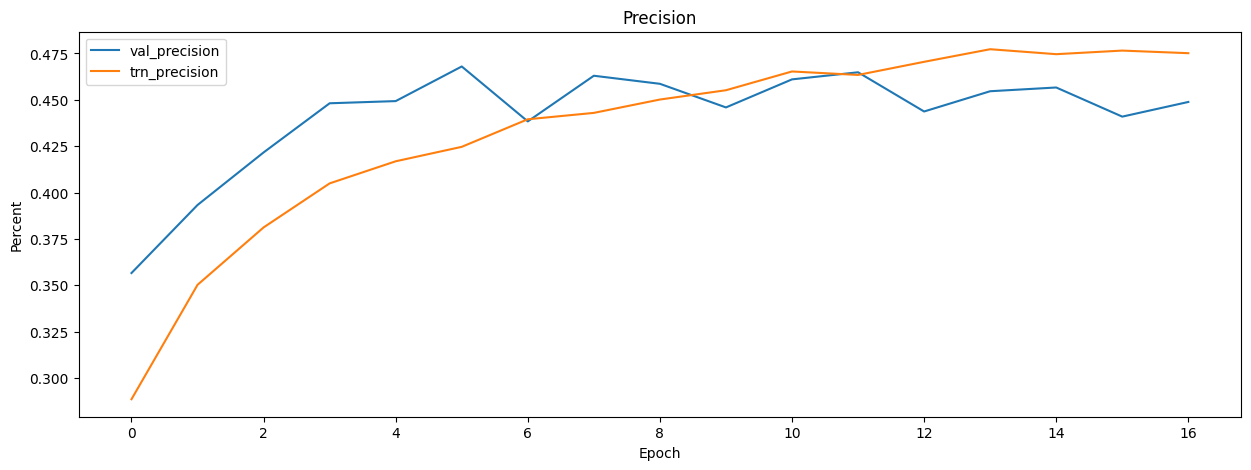

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_precision'],label='val_precision')
plt.plot(range(history.epoch[-1]+1),history.history['precision'],label='trn_precision')
plt.title('Precision'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

###save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2')

## MobileNetV2 for Superclass

###Load super class data

In [ ]:
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_superclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

### Create the model
 whose weights are generated in the previous step, when training with the fine classes.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 8

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './dataset_superclass'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 155474 images belonging to 8 classes.
Found 38865 images belonging to 8 classes.


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2')
# Agregar una nueva capa de salida personalizada
new_output_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax', name='superClass')(model.layers[-1].output)

# Crear un nuevo modelo con la capa de salida personalizada
model = keras.models.Model(inputs=model.input, outputs=new_output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 180)               230580    
                                                                 
 superClass (Dense)          (None, 8)                 1448      
                                                                 
Total params: 2,490,012
Trainable params: 232,028
Non-train

### Evaluate model

In [ ]:
from keras.api._v2.keras import callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model.compile(optimizer=keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                    tf.keras.metrics.Precision(name='precision')])
history = model.fit(train_batches, epochs=20, validation_data=valid_batches, callbacks=[callback])


Epoch 1/20
4859/4859 [==============================] - 520s 106ms/step - loss: 1.4746 - accuracy: 0.6502 - top_5_accuracy: 0.9375 - precision: 0.8067 - val_loss: 1.3147 - val_accuracy: 0.6201 - val_top_5_accuracy: 0.9342 - val_precision: 0.7098
Epoch 2/20
4859/4859 [==============================] - 515s 106ms/step - loss: 1.0589 - accuracy: 0.7097 - top_5_accuracy: 0.9512 - precision: 0.7745 - val_loss: 1.2337 - val_accuracy: 0.6330 - val_top_5_accuracy: 0.9317 - val_precision: 0.6789
Epoch 3/20
4859/4859 [==============================] - 510s 105ms/step - loss: 0.9711 - accuracy: 0.7240 - top_5_accuracy: 0.9542 - precision: 0.7824 - val_loss: 1.2043 - val_accuracy: 0.6263 - val_top_5_accuracy: 0.9442 - val_precision: 0.7099
Epoch 4/20
4859/4859 [==============================] - 516s 106ms/step - loss: 0.9302 - accuracy: 0.7311 - top_5_accuracy: 0.9581 - precision: 0.7959 - val_loss: 1.2058 - val_accuracy: 0.6278 - val_top_5_accuracy: 0.9385 - val_precision: 0.7011
Epoch 5/20
4859/

###print results

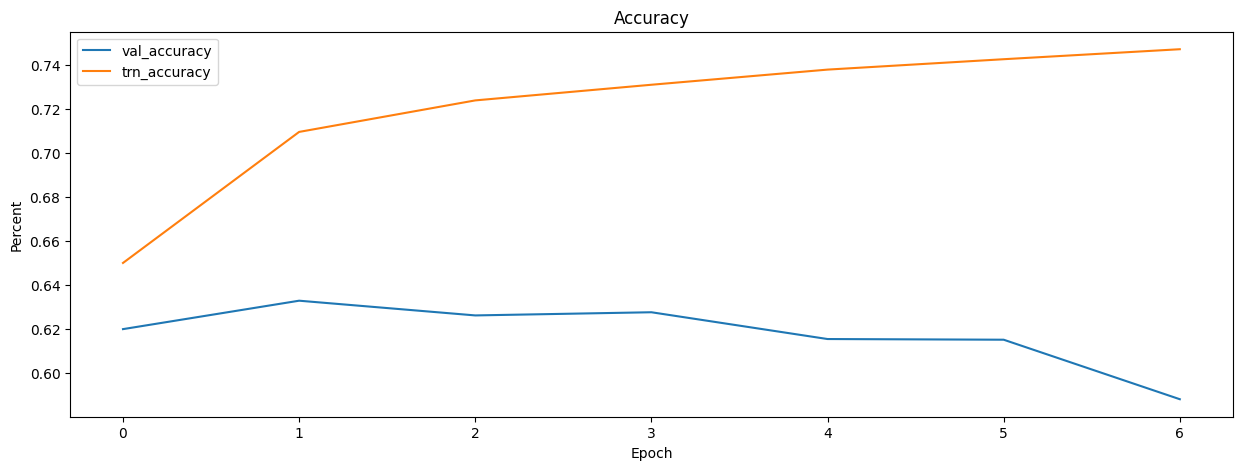

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_accuracy'],label='val_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['accuracy'],label='trn_accuracy')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

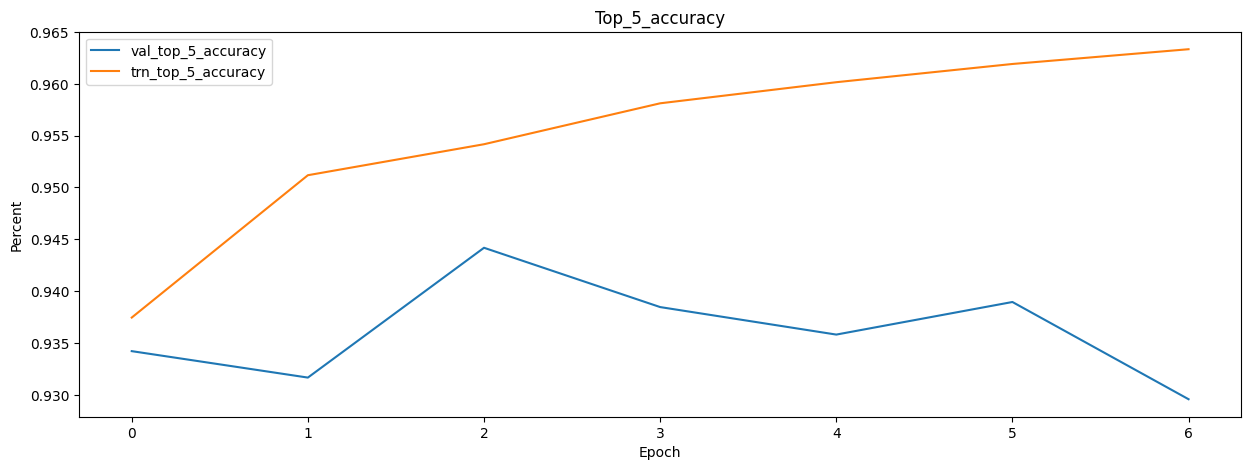

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_top_5_accuracy'],label='val_top_5_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['top_5_accuracy'],label='trn_top_5_accuracy')
plt.title('Top_5_accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

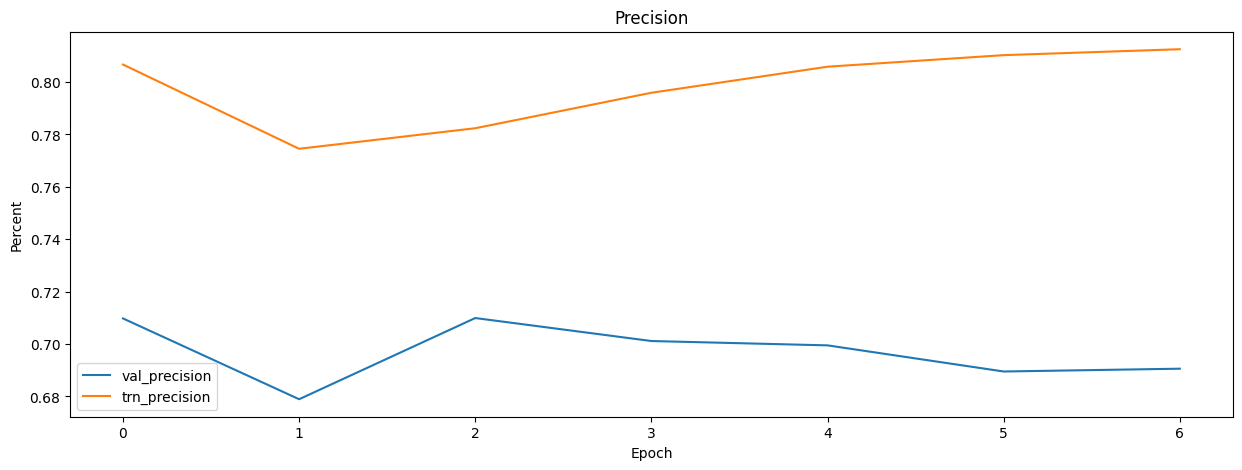

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_precision'],label='val_precision')
plt.plot(range(history.epoch[-1]+1),history.history['precision'],label='trn_precision')
plt.title('Precision'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

###save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_superClass')

##Fine-tuning subClass

###Load data

In [ ]:
#drive.mount('/content/drive')
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_subclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 180

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './training_data'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 157028 images belonging to 180 classes.
Found 39167 images belonging to 180 classes.


###Load model previous

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2')
model.trainable=True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 180)               230580    
                                                                 
Total params: 2,488,564
Trainable params: 2,454,452
Non-trainable params: 34,112
_________________________________________________________________


###Evaluate model

In [ ]:
from keras.api._v2.keras import callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model.compile(optimizer=keras.optimizers.Adam(1e-5),
                loss="categorical_crossentropy",
                metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                    tf.keras.metrics.Precision(name='precision')])
history = model.fit(train_batches, epochs=25, validation_data=valid_batches, callbacks=[callback])


Epoch 1/25
4908/4908 [==============================] - 877s 171ms/step - loss: 2.0550 - accuracy: 0.4779 - top_5_accuracy: 0.7727 - precision: 0.7166 - val_loss: 2.2616 - val_accuracy: 0.4482 - val_top_5_accuracy: 0.7440 - val_precision: 0.6712
Epoch 2/25
4908/4908 [==============================] - 888s 181ms/step - loss: 1.8585 - accuracy: 0.5184 - top_5_accuracy: 0.8043 - precision: 0.7461 - val_loss: 2.1923 - val_accuracy: 0.4609 - val_top_5_accuracy: 0.7566 - val_precision: 0.6783
Epoch 3/25
4908/4908 [==============================] - 835s 170ms/step - loss: 1.7367 - accuracy: 0.5447 - top_5_accuracy: 0.8246 - precision: 0.7639 - val_loss: 2.1933 - val_accuracy: 0.4660 - val_top_5_accuracy: 0.7587 - val_precision: 0.6693
Epoch 4/25
4908/4908 [==============================] - 834s 170ms/step - loss: 1.6372 - accuracy: 0.5672 - top_5_accuracy: 0.8394 - precision: 0.7776 - val_loss: 2.2000 - val_accuracy: 0.4675 - val_top_5_accuracy: 0.7634 - val_precision: 0.6541
Epoch 5/25
4908/

###print results

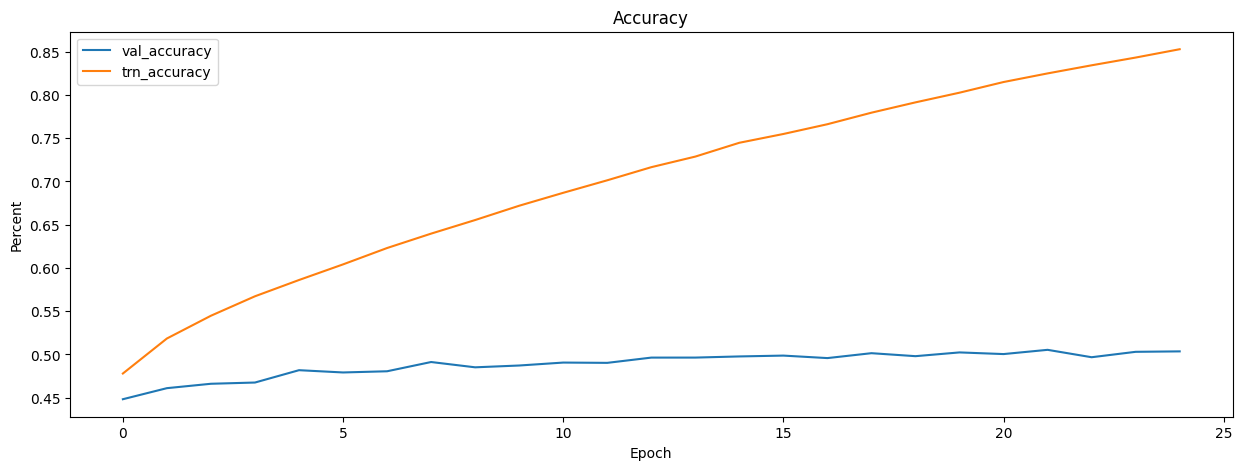

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_accuracy'],label='val_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['accuracy'],label='trn_accuracy')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

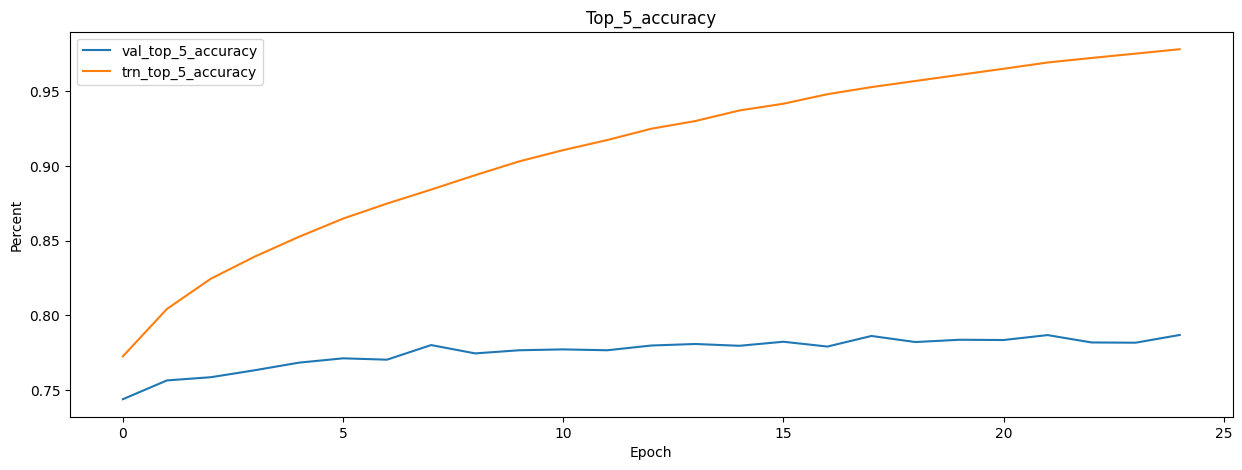

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_top_5_accuracy'],label='val_top_5_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['top_5_accuracy'],label='trn_top_5_accuracy')
plt.title('Top_5_accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

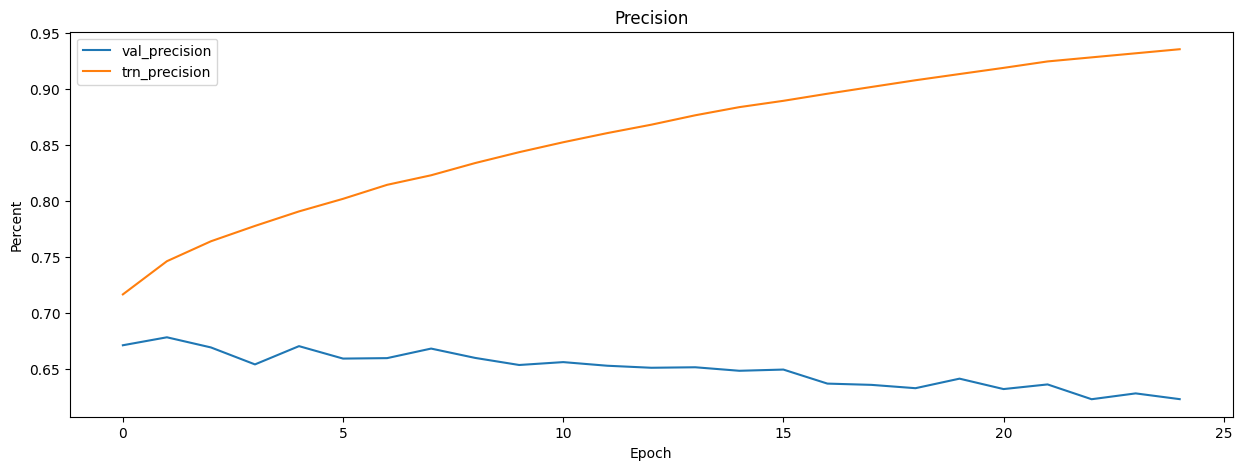

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_precision'],label='val_precision')
plt.plot(range(history.epoch[-1]+1),history.history['precision'],label='trn_precision')
plt.title('Precision'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

###save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_fineTuning')

##Fine-tuning superClass

###Load data

In [ ]:
#drive.mount('/content/drive')
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_superclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 8

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './dataset_superclass'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 155474 images belonging to 8 classes.
Found 38865 images belonging to 8 classes.


###Load model previous

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_superClass')
model.trainable=True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 180)               230580    
                                                                 
 superClass (Dense)          (None, 8)                 1448      
                                                                 
Total params: 2,490,012
Trainable params: 2,455,900
Non-tra

###Evaluate model

In [ ]:
from keras.api._v2.keras import callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model.compile(optimizer=keras.optimizers.Adam(1e-5),
                loss="categorical_crossentropy",
                metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                    tf.keras.metrics.Precision(name='precision')])
history = model.fit(train_batches, epochs=15, validation_data=valid_batches, callbacks=[callback])


Epoch 1/15
4859/4859 [==============================] - 878s 174ms/step - loss: 0.8589 - accuracy: 0.7429 - top_5_accuracy: 0.9651 - precision: 0.8185 - val_loss: 1.1495 - val_accuracy: 0.6312 - val_top_5_accuracy: 0.9495 - val_precision: 0.7203
Epoch 2/15
4859/4859 [==============================] - 844s 174ms/step - loss: 0.7843 - accuracy: 0.7689 - top_5_accuracy: 0.9698 - precision: 0.8438 - val_loss: 1.1333 - val_accuracy: 0.6308 - val_top_5_accuracy: 0.9490 - val_precision: 0.7268
Epoch 3/15
4859/4859 [==============================] - 843s 173ms/step - loss: 0.7301 - accuracy: 0.7894 - top_5_accuracy: 0.9726 - precision: 0.8604 - val_loss: 1.1121 - val_accuracy: 0.6451 - val_top_5_accuracy: 0.9482 - val_precision: 0.7341
Epoch 4/15
4859/4859 [==============================] - 843s 174ms/step - loss: 0.6859 - accuracy: 0.8070 - top_5_accuracy: 0.9755 - precision: 0.8740 - val_loss: 1.1176 - val_accuracy: 0.6393 - val_top_5_accuracy: 0.9462 - val_precision: 0.7266
Epoch 5/15
4859/

###print results

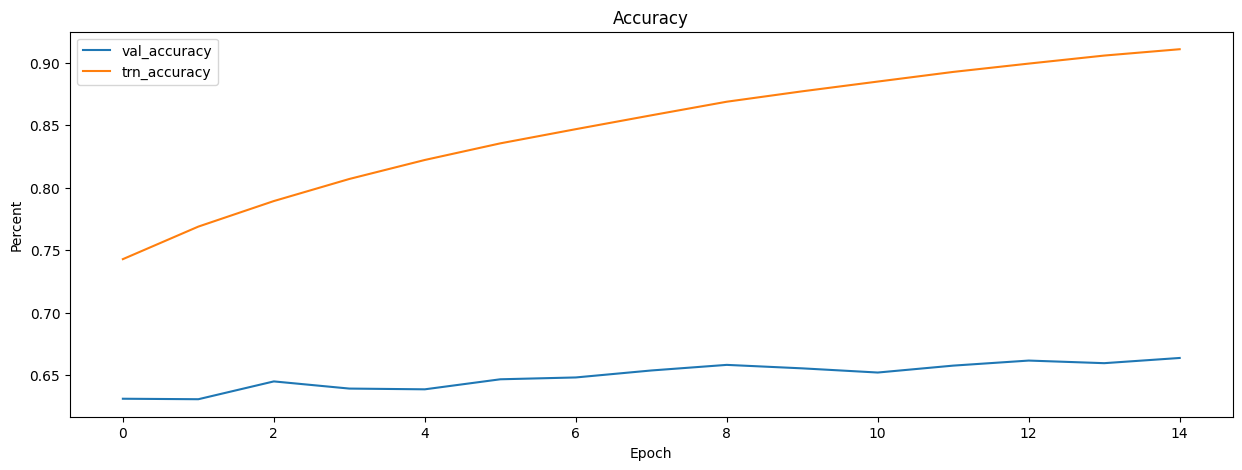

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_accuracy'],label='val_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['accuracy'],label='trn_accuracy')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

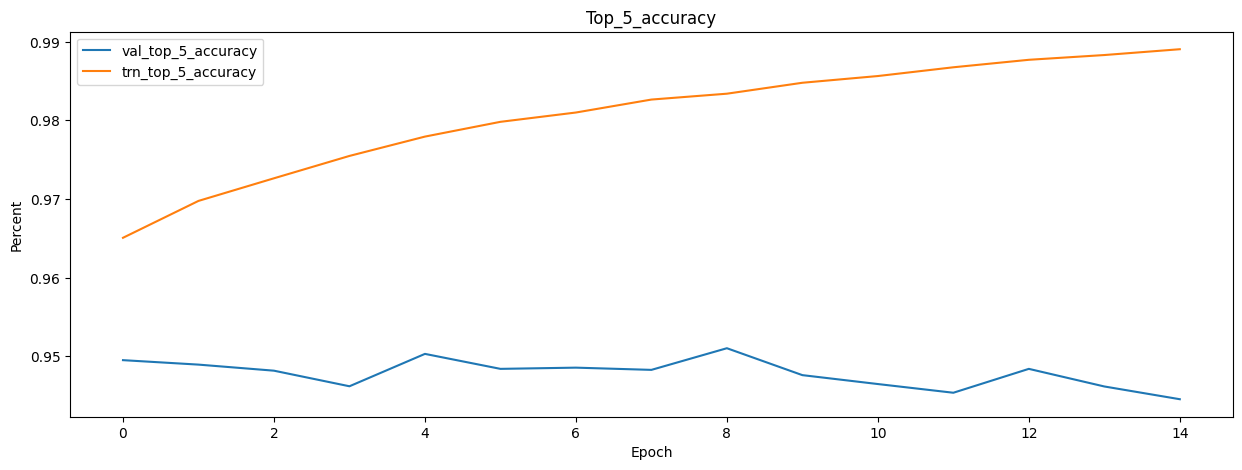

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_top_5_accuracy'],label='val_top_5_accuracy')
plt.plot(range(history.epoch[-1]+1),history.history['top_5_accuracy'],label='trn_top_5_accuracy')
plt.title('Top_5_accuracy'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

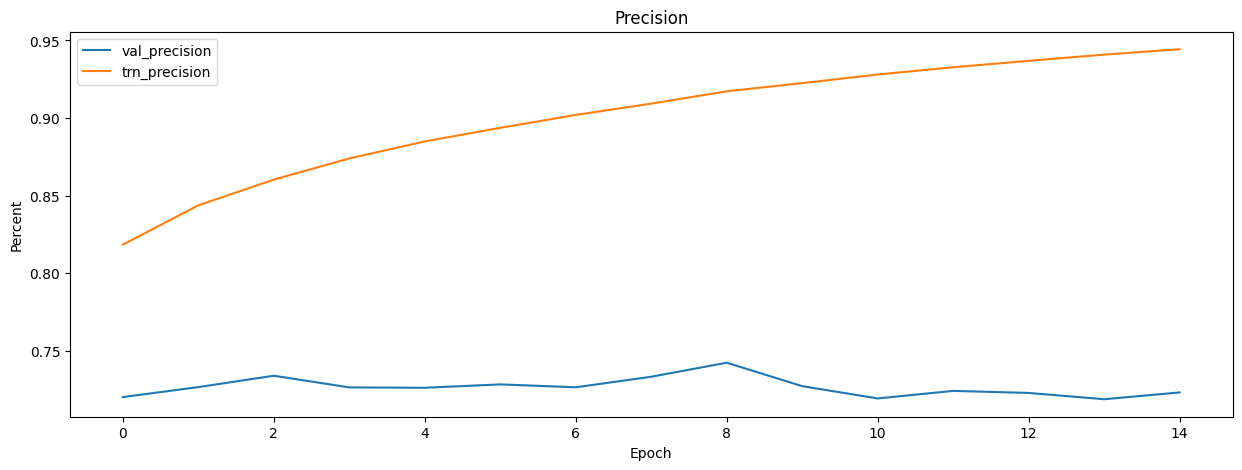

In [ ]:
# Construyamos horarios de entrenamiento
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_precision'],label='val_precision')
plt.plot(range(history.epoch[-1]+1),history.history['precision'],label='trn_precision')
plt.title('Precision'); plt.xlabel('Epoch'); plt.ylabel('Percent');plt.legend();
plt.show()

###save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_SuperClass_fineTuning')

In [ ]:
from google.colab import runtime
runtime.unassign

<function google.colab.runtime.unassign()>

##Confusion Matrix

###Importar los paquetes

In [ ]:
from tensorflow import keras
from google.colab import drive
from sklearn.metrics import confusion_matrix
import zipfile
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

###Montar drive y definir el tamaño


In [ ]:
#drive.mount('/content/drive')
BATCH_SIZE = 32
IMG_SIZE = 224

###Clases padres

In [ ]:
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_superclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './dataset_superclass'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 155474 images belonging to 8 classes.
Found 38865 images belonging to 8 classes.


<ipython-input-43-a2f29dbd40dc>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_batches)


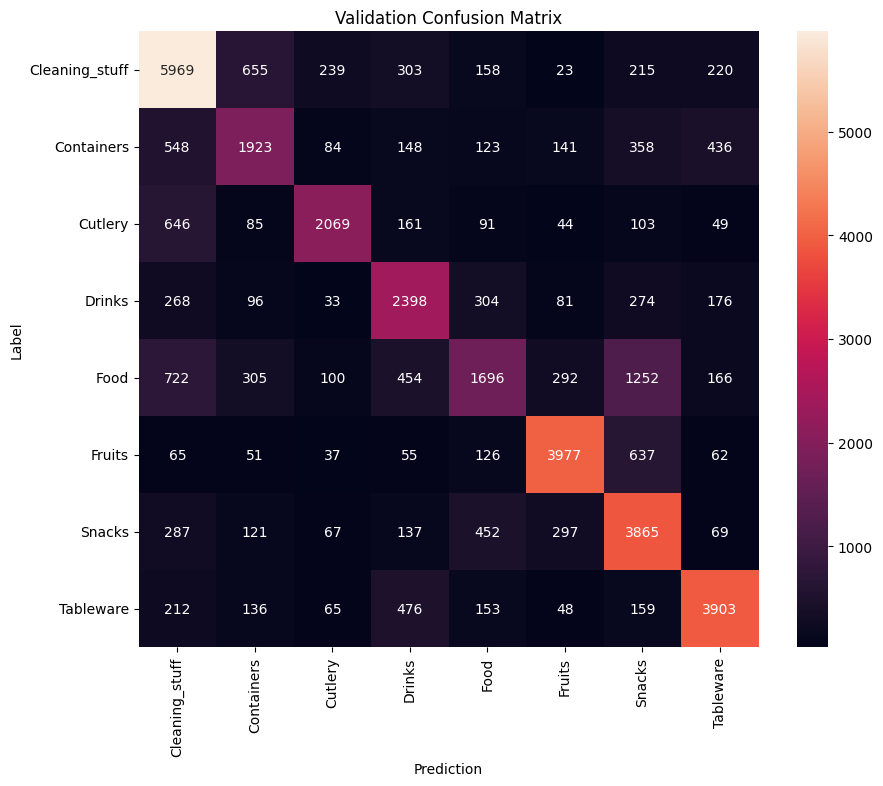

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_SuperClass_fineTuning')

class_names = ['Cleaning_stuff', 'Containers', 'Cutlery', 'Drinks', 'Food', 'Fruits', 'Snacks', 'Tableware']

# Obtener las predicciones del modelo en el conjunto de validación
predictions = model.predict_generator(valid_batches)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del conjunto de validación
true_classes = valid_batches.classes

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

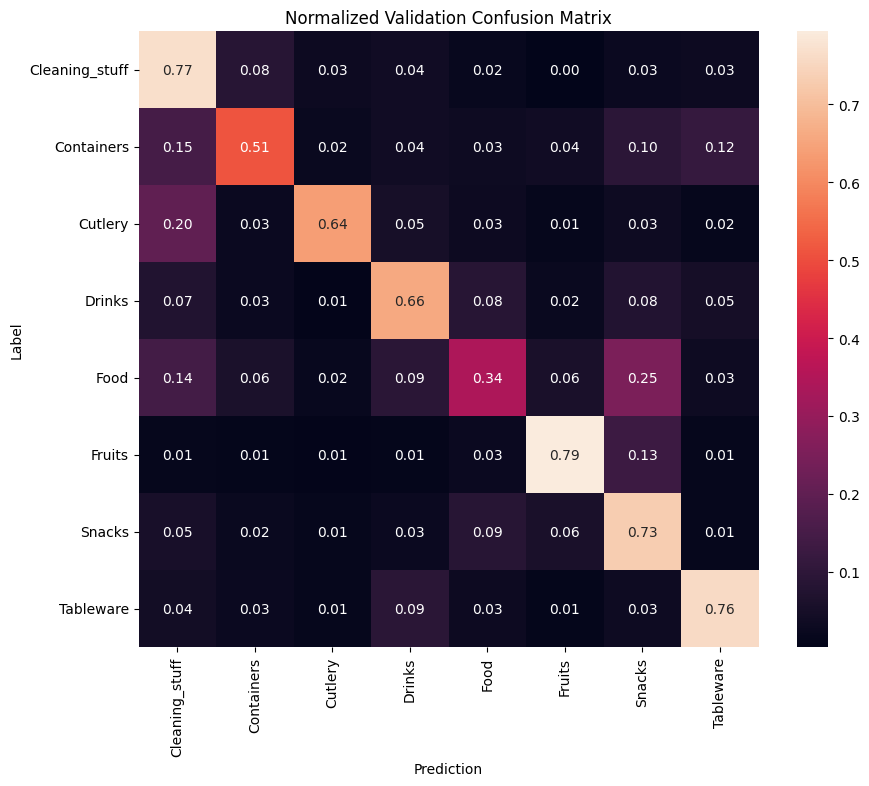

In [ ]:
# Calcular el porcentaje de acierto para cada clase
class_totals = np.sum(confusion_mtx, axis=1)  # Total de instancias por clase
confusion_mtx_norm = confusion_mtx.astype('float') / class_totals[:, np.newaxis]  # Dividir cada elemento por el total de instancias en la clase correspondiente

# Plotear la matriz de confusión normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx_norm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".2f"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Normalized Validation Confusion Matrix")
plt.show()

###Clases hijos

In [ ]:
ruta_archivo_zip = '/content/drive/MyDrive/Colab Notebooks/data_subclass.zip'
ruta_destino = './'
with zipfile.ZipFile(ruta_archivo_zip, 'r') as archivo_zip:
    # Extraer el archivo deseado en la ruta de destino
    archivo_zip.extractall(ruta_destino)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_path = './training_data'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.2, horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False, seed=42, subset='training')
valid_batches = train_datagen.flow_from_directory(
    data_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle = False,seed=42, subset='validation')

Found 157028 images belonging to 180 classes.
Found 39167 images belonging to 180 classes.


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_models/MobileNetV2_fineTuning')

# Obtener las predicciones del modelo en el conjunto de validación
predictions = model.predict_generator(valid_batches)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del conjunto de validación
true_classes = valid_batches.classes

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

<ipython-input-47-d634e3be01d7>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_batches)


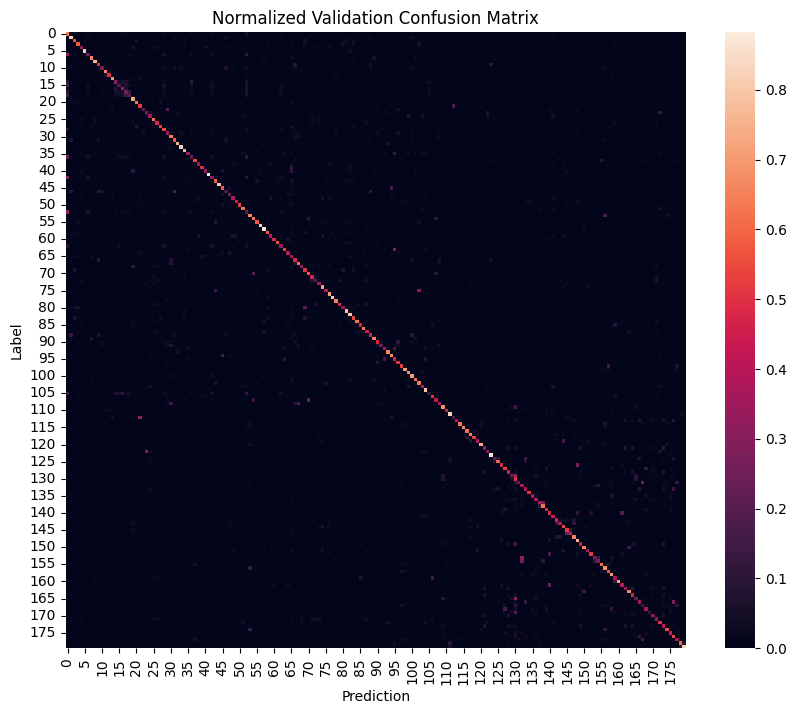

In [ ]:
# Calcular el porcentaje de acierto para cada clase
class_totals = np.sum(confusion_mtx, axis=1)  # Total de instancias por clase
confusion_mtx_norm = confusion_mtx.astype('float') / class_totals[:, np.newaxis]  # Dividir cada elemento por el total de instancias en la clase correspondiente

# Plotear la matriz de confusión normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx_norm)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Normalized Validation Confusion Matrix")
plt.show()